In [112]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random

In [113]:
def networx_to_stucture_part(G : nx.Graph):
    """
    Converts a networkx graph to a tensor representation
    """
    adj = nx.adjacency_matrix(G).todense()
    identity = np.identity(adj.shape[0])
    adj_tild = adj + identity
    degrees = np.sum(adj_tild, axis=1)
    d_tild = np.diag(np.power(degrees, -0.5))
    stucture_part = np.matmul(np.matmul(d_tild, adj_tild), d_tild)
    return stucture_part

In [ ]:
class GCN_layer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCN_layer, self).__init__()
        self.W = nn.Parameter(torch.zeros(in_features, out_features), requires_grad=True)
        self.b = nn.Parameter(torch.zeros(out_features), requires_grad=True)
        nn.init.xavier_uniform_(self.W.data)
        nn.init.zeros_(self.b.data)

    def forward(self,X,structure_part):
        """
        X: input features
        G: nx.Graph graph
        """

        """X = torch.tensor(X).float().requires_grad_(False)"""
        output = torch.matmul(structure_part,X)
        output = torch.matmul(output,self.W) + self.b

        return output




In [111]:
class GCN_network(nn.Module):
    def __init__(self, in_features, out_features, hidden_features=64, dropout=0.5,num_layers=2):
        super(GCN_network, self).__init__()
        self.layers = nn.ModuleList()  # Create a ModuleList to store GCN layers

        # Add GCN layers to the ModuleList
        self.layers.append(GCN_layer(in_features, hidden_features))
        for _ in range(num_layers - 1):  # Add (num_layers - 1) additional GCN layers
            self.layers.append(GCN_layer(hidden_features, hidden_features))

        # Output layer
        self.layer_out = GCN_layer(hidden_features, out_features)
        self.dropout = dropout
    def forward(self,X,G : nx.Graph):
        """
        X: input features
        G: nx.Graph graph
        """
        tensor_graph = torch.tensor(networx_to_stucture_part(G),dtype=torch.float32)

        X = torch.tensor(X).float()
        for layer in self.layers:
            X = layer(X, tensor_graph)
            X = F.relu(X)
            X = F.dropout(X, p=self.dropout)
        output = self.layer_out(X, tensor_graph)

        return output


In [110]:
def generate_graph(numb_nodes=20):
    random_graph = nx.path_graph(numb_nodes)
    # apply one dimension features to node, a random number between 0 and 1

    #print(random_graph.nodes.data())
    num_features = 1
    # plot the graph

    # put all the features in a numpy array
    features_complete = np.zeros((len(random_graph.nodes),num_features))
    features_masked = np.zeros((len(random_graph.nodes),num_features))
    # get two random nodes in the graph
    node1 = random.choice(list(random_graph.nodes))
    node2 = random.choice(list(random_graph.nodes))
    # compute the shortest path between the two nodes
    shortest_path = nx.shortest_path(random_graph, node1, node2)
    #print(shortest_path)
    # put the features of the shortest path nodes to 1, as  a dict

    for node in random_graph.nodes:
        if node in shortest_path:
            features_complete[node] = 1
        else:
            features_complete[node] = 0
    # plot graph. Node that the shortest path nodes are colored in red
    for node in random_graph.nodes:
        if node in shortest_path:
            random_graph.nodes[node]['features'] = 1
        else:
            random_graph.nodes[node]['features'] = 0

    nx.draw(random_graph, with_labels=True, node_color=[random_graph.nodes[node]['features'] for node in random_graph.nodes])
    #print(features_complete)
    # features masked has only the departure and arrival nodes of the shortest path
    features_masked[shortest_path[0]] = 1
    features_masked[shortest_path[-1]] = 1
    return features_complete, features_masked, random_graph


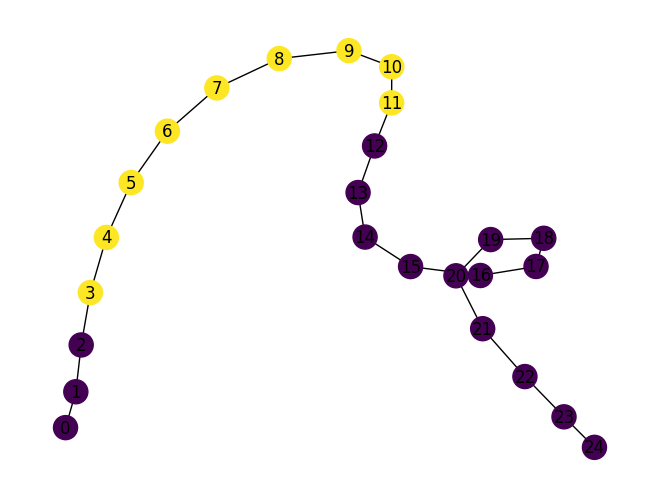

In [111]:
number_graph_instances = 1
numb_nodes = 25
generated_data = []

for _ in range(number_graph_instances):
    features_complete, features_masked, random_graph = generate_graph(numb_nodes)
    generated_data.append((features_complete, features_masked, random_graph))


num_features = 1
features_complete = np.array([generated_data[i][0] for i in range(number_graph_instances)])
features_masked = np.array([generated_data[i][1] for i in range(number_graph_instances)])
graphs = []
for i in range(len(generated_data)):
    graphs.append(generated_data[i][2])



In [114]:
model = GCN_network(in_features=num_features, out_features=2, hidden_features=128, dropout=0.2,num_layers=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = model.to(device)

with torch.no_grad():
    for graph, features in zip(graphs, features_masked):
        output = model(features, graph)



# remove the last dimension of features_complete and features_masked


In [115]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [116]:
print(model.layers[0].W)

Parameter containing:
tensor([[ 0.0464, -0.1349,  0.0460,  0.1011,  0.2001,  0.1284,  0.1295, -0.1545,
         -0.0360, -0.0165,  0.0329,  0.0908,  0.0991,  0.0669,  0.0287, -0.0526,
          0.1928,  0.0128,  0.0370,  0.1239, -0.1809,  0.0051,  0.1151,  0.0539,
         -0.1285,  0.1132,  0.0037,  0.0060,  0.0472, -0.2028, -0.1025,  0.0723,
         -0.1069, -0.0418,  0.1521,  0.1036,  0.2078,  0.0532,  0.0251,  0.0452,
         -0.1104,  0.0397,  0.0425,  0.1274,  0.1716, -0.1883, -0.0104,  0.0070,
          0.1847, -0.0848, -0.0839,  0.0353,  0.1711,  0.1037,  0.2064,  0.1699,
          0.1585, -0.0853, -0.0743, -0.0099, -0.0928, -0.0906, -0.0412, -0.0128,
          0.1970,  0.0673, -0.0404, -0.1974,  0.0831,  0.1119, -0.1534,  0.0438,
          0.0215,  0.1129, -0.1309, -0.1960, -0.1942, -0.2083,  0.2034, -0.1649,
          0.0499,  0.1747, -0.1872,  0.0225, -0.1008, -0.1707, -0.0939, -0.0782,
          0.0696,  0.1020,  0.1565,  0.0892, -0.1329, -0.1934, -0.0165,  0.0647,
      

In [117]:
epoch = 1000

for i in range(epoch):
    curr_loss = 0
    for graph, features ,features_complete_unit in zip(graphs, features_masked,features_complete):
        features_complete_tensor = torch.tensor(features_complete_unit,dtype=torch.long).requires_grad_(False).view(-1)
        output = model(features, graph)

        loss = criterion(output,features_complete_tensor)
        loss.backward()
        optimizer.step()
        curr_loss += loss.item()
        optimizer.zero_grad()
    print(f"Epoch: {i} Loss: {curr_loss/len(graphs)}")


Epoch: 0 Loss: 0.63987124979496
Epoch: 1 Loss: 0.6014221954345703
Epoch: 2 Loss: 0.5991747307777405
Epoch: 3 Loss: 0.599862830042839
Epoch: 4 Loss: 0.5986453270912171
Epoch: 5 Loss: 0.5978331077098846
Epoch: 6 Loss: 0.5966593226790429
Epoch: 7 Loss: 0.5960681748390197
Epoch: 8 Loss: 0.5937690153717995
Epoch: 9 Loss: 0.5949025440216065
Epoch: 10 Loss: 0.5949787360429764
Epoch: 11 Loss: 0.5963852819800377
Epoch: 12 Loss: 0.5965618932247162
Epoch: 13 Loss: 0.5965009590983391
Epoch: 14 Loss: 0.59333231985569
Epoch: 15 Loss: 0.595572527050972
Epoch: 16 Loss: 0.5948088866472244
Epoch: 17 Loss: 0.5923880445957184
Epoch: 18 Loss: 0.591588343679905
Epoch: 19 Loss: 0.5914055007696152
Epoch: 20 Loss: 0.5922241979837417
Epoch: 21 Loss: 0.5921096059679986
Epoch: 22 Loss: 0.5905765262246132
Epoch: 23 Loss: 0.5888151675462723
Epoch: 24 Loss: 0.5922275674343109
Epoch: 25 Loss: 0.591286937892437
Epoch: 26 Loss: 0.5892174407839775
Epoch: 27 Loss: 0.5894157707691192
Epoch: 28 Loss: 0.5926876756548881
Epo

In [107]:
# plot the graph. The shortest path is colored in red
with torch.no_grad():
    accuracy = 0
    for graph, features ,features_complete_unit in zip(graphs, features_masked,features_complete):
        features_complete_tensor = torch.tensor(features_complete_unit,dtype=torch.long).requires_grad_(False).view(-1)
        output = model(features, graph)
        predicted = (torch.argmax(output, dim=1))
        accuracy += (torch.sum(predicted == features_complete_tensor).item()/len(predicted))
    print(f"Accuracy: {accuracy/len(graphs)}%")

Accuracy: 0.8088%
